# Identify Fraud from Enron Emails and Financial Data
### Background
Enron Corporation was an American energy, commodities, and services company based in Houston, Texas. And it was one of the largest companies in the United States in 2000. By 2002, it had collapsed into bankruptcy due to large amount of accounting and corporate corporate fraud. Its collapse affected thousands of its employees, shook Wall Street and influenced the whole Western economic system.

In this project, a person of interest identifier will be built using the financial and email data made public as a result of the Enron scandal. 

### Data Exploration

In [2]:
# %load poi_id.py
#!/usr/bin/python
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data


In [3]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    

In [4]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
poi = ['poi']
financial_features_list = ['salary', 
                           'deferral_payments', 
                           'total_payments', 
                           'loan_advances', 'bonus', 
                           'restricted_stock_deferred',
                           'deferred_income', 
                           'total_stock_value', 
                           'expenses', 
                           'exercised_stock_options', 
                           'other', 
                           'long_term_incentive', 
                           'restricted_stock', 
                           'director_fees'] 
email_features_list = ['to_messages', 
                       'email_address',
                       'from_poi_to_this_person',
                       'from_messages', 
                       'from_this_person_to_poi',
                       'shared_receipt_with_poi']
    
features_list = poi + financial_features_list +email_features_list


In [5]:
# Total number of data point
print""
print "Number of data points: ", len(data_dict.keys())

# Allocation across classes (POI/ non-POI)
poi = 0
for people in data_dict:
    if data_dict[people]['poi'] == 1:
        poi += 1
non_poi = len(data_dict.keys()) - poi
print "Number of Person of Interest: ", poi
print "Number of non Person of Interest: ", non_poi
print "Precetage of Person of Interest in the dataset: ", float(poi)/ non_poi*100,"%"



Number of data points:  146
Number of Person of Interest:  18
Number of non Person of Interest:  128
Precetage of Person of Interest in the dataset:  14.0625 %


This dataset contains 146 number of data points, but only 18(14.06%) people are the Person of Interest(POI). The disproportionate number of class instances will arise the class imbalance problem, a common problem in machine learning that the total number of a class of data (positive) is far less than the total number of another class of data (negative). 

###  Alternative Metrics to Evaluate Algorithm Performance

To address the problem, instead of using general accuracy of counting number of mistales, an aternative metrics (Precision, Recall and F1 score) will be used. Precision is used to determine the fraction of relevant instances (True Positive) among the retrieved instances (True Positive + False Positive). In this case, a great precision will be whenever a POI gets flagged in the test set, we have confidence that it is a real POI but not a false alarm. 

On the other hand, recall is used to detemine the fraction of relevant instances (True Positive) that have been retrieved over total relevant instances (True Positive + False Negative). For example, a great recall will be the identifier can successfully identify the POI everytimes he/ she shows up in the test set. 

F1 score is the a measure that combines precision and recall and is the harmonic mean of precision and recall. A great F1 score what we prefer as both the False Positive abd False Negative rates are low. In such case, if the identifier finds a POI, then the person is almost certainly a POI; and if the identifier does not flag someone, then he/ she are almost certainly not a POI. 

In [6]:
# Number of features used
print "Number of features: ", (len(data_dict[people].keys()))

# Missing values
missing_dict= {}
for features in data_dict[people]:
    missing_dict[features] = 0

for people in data_dict:
    for features in data_dict[people]:
        if data_dict[people][features] == "NaN":
            missing_dict[features] += 1

print "Missing values of each features:"

name_list = []
score_list = []
percentage_list = []
for name, score in sorted(missing_dict.iteritems(), key=lambda item:item[1], reverse=True):
    name_list.append(name)
    score_list.append(score)
for value in score_list:
    percentage_list.append(value/146.0)
import pandas as pd
missing_value_table = pd.DataFrame({"Missing value": score_list, "Percentage": percentage_list}, index = name_list)
print missing_value_table


Number of features:  21
Missing values of each features:
                           Missing value  Percentage
loan_advances                        142    0.972603
director_fees                        129    0.883562
restricted_stock_deferred            128    0.876712
deferral_payments                    107    0.732877
deferred_income                       97    0.664384
long_term_incentive                   80    0.547945
bonus                                 64    0.438356
to_messages                           60    0.410959
shared_receipt_with_poi               60    0.410959
from_messages                         60    0.410959
from_poi_to_this_person               60    0.410959
from_this_person_to_poi               60    0.410959
other                                 53    0.363014
salary                                51    0.349315
expenses                              51    0.349315
exercised_stock_options               44    0.301370
restricted_stock                      36  

The dataset has 21 features. These features inlcude financial features, email_features and the label of whether the person is a person of interest. Almost of these features have missing values.

### Outlier Investigation

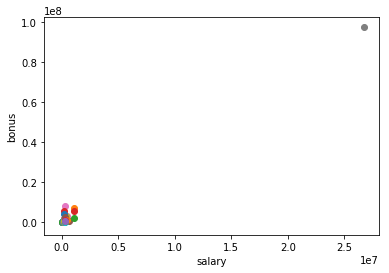

In [7]:
import matplotlib.pyplot
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)


### your code below
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()


In [8]:
### Task 2: Remove outliers 
data_dict.pop("TOTAL", "None" )

# Cleaning the data
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", "None" )
data_dict.pop("LOCKHART EUGENE E", "None" )
print "Data point: ", len(data_dict.keys())


Data point:  143


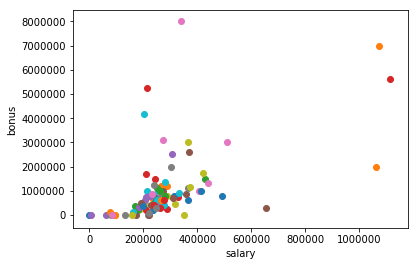

In [9]:
import sys
import matplotlib.pyplot
features = ["salary", "bonus"]
data = featureFormat(data_dict, features)


### your code below
for point in data:
    salary = point[0]
    bonus = point[1]
    matplotlib.pyplot.scatter( salary, bonus )

matplotlib.pyplot.xlabel("salary")
matplotlib.pyplot.ylabel("bonus")
matplotlib.pyplot.show()


The scatter plot has clearly shows that there is a hugh outlier generated by the "Total" row, so I removed it from the dataset. I also removed the information of the "THE TRAVEL AGENCY IN THE PARK" as it is an agency but not an employee.
Futhermore, I removed the entry of "LOCKHART EUGENE E" as it contains only missing values. After clearning the data, the dataset remains 143 data points. 

### Create New Features 


In [10]:
# Performance
import pickle
import sys
from sklearn.cross_validation import train_test_split
from feature_format import featureFormat, targetFeatureSplit

def performance(clf_u, dataset, the_features_list):
    # Extract features and labels from dataset for local testing
    data = featureFormat(dataset, the_features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
       
    ### fit the classifier using training set, and test on test set
    clf_u.fit(features_train, labels_train)
    predictions = clf_u.predict(features_test)
    for prediction, truth in zip(predictions, labels_test):
        if prediction == 0 and truth == 0:
            true_negatives += 1
        elif prediction == 0 and truth == 1:
            false_negatives += 1
        elif prediction == 1 and truth == 0:
            false_positives += 1
        elif prediction == 1 and truth == 1:
            true_positives += 1
        else:
            print "Warning: Found a predicted label not == 0 or 1."
            print "All predictions should take value 0 or 1."
            print "Evaluating performance for processed predictions:"
            break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        return clf_u, accuracy, precision, recall, f1, f2
    except:
        print "Got a divide by zero when trying out:", clf_u
        print "Precision or recall may be undefined due to a lack of true positive predicitons."
        
# print the performance
def print_performance(clf, accuracy, precision, recall, f1, f2):
    print "Performance of", clf
    print "     Accuracy:", accuracy, ",Precision:", precision, ",Recall:", recall, ",F1:", f1
    

In [11]:
features_list.remove("email_address")


In [12]:
# performance before adding new features
from sklearn.naive_bayes import GaussianNB
clf_bnf = GaussianNB()
clf_bnf, accuracy_b, precision_b, recall_b, f1_b, f2_b = performance(clf_bnf, data_dict, features_list)

# Task 3: Create new feature(s)
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    if poi_messages != "NaN" and all_messages != "NaN":
        fraction = float(poi_messages)/ all_messages
        
    else:
        fraction = 0
    return fraction

for name in data_dict:
    data_point = data_dict[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi
features_list = features_list + ["fraction_from_poi"] + ["fraction_to_poi"] 

# Store to my_dataset for easy export below.
my_dataset = data_dict

# performance after adding new features
clf_anf = GaussianNB()
clf_anf, accuracy, precision, recall, f1, f2 = performance(clf_anf, my_dataset, features_list)

# compareing the performance before and after adding the new features 
accuracy_list = []
precision_list = []
recall_list =[]
f1_list =[]
features_status_list = ["Before adding new features", "After adding new features", "Improved:"]
accuracy_list = [accuracy_b, accuracy, -(accuracy_b - accuracy)]
precision_list = [precision_b, precision, -(precision_b - precision)]
recall_list =[recall_b, recall, -(recall_b - recall)]
f1_list =[f1_b, f1, -(f1_b - f1)]
     
status_table_1 = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                             "Recall": recall_list, "F1": f1_list}, index = features_status_list)
print "The preformance before and after adding the new features:"
print status_table_1


The preformance before and after adding the new features:
                            Accuracy        F1  Precision  Recall
Before adding new features  0.883721  0.444444        0.5     0.4
After adding new features   0.883721  0.444444        0.5     0.4
Improved:                  -0.000000 -0.000000       -0.0    -0.0


Since people who have higher frequencies of receiving and sending email with Persons of Interest may also be a Person of Interest too, I create two new features("fraction_from_poi", "fraction_to_poi") which caputure the fraction of emails the person sent to Persons of Interest and the fraction of emails received from Persons of interest. Although the performance has not improved in the mean time, one of the new features, "fraction_to_poi", turns out to be relatively important and has been choosed in the SelectKBest feature selection.

### Feature Scaling

In [13]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features= scaler.fit_transform(features)
                               

In [14]:
clf_bfs = GaussianNB()
clf_bfs, accuracy_s, precision_s, recall_s, f1_s, f2_s = performance(clf_bfs, my_dataset, features_list)

features_status_list = ["Before feature scaling", "After feature scaling", "Improved:"]
accuracy_list = [accuracy, accuracy_s, -(accuracy - accuracy_s)]
precision_list = [precision, precision_s, -(precision - precision_s)]
recall_list =[recall, recall_s, -(recall - recall_s)]
f1_list =[f1, f1_s, -(f1 - f1_s)]
     
status_table_2 = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                             "Recall": recall_list, "F1": f1_list}, index = features_status_list)
print "The preformance before and after feature selection:"
print status_table_2


The preformance before and after feature selection:
                        Accuracy        F1  Precision  Recall
Before feature scaling  0.883721  0.444444        0.5     0.4
After feature scaling   0.883721  0.444444        0.5     0.4
Improved:              -0.000000 -0.000000       -0.0    -0.0


Feature scaling is a method used to standardize the range of independent variables or features of data. The table shows the preformance does not improve after scaling the features as Gaussian Naive Bayes has been used as the classifier, and its parameter estimation doesn't involve optimization. The reason feature scaling has been performed as KMeans Clustering will be attempted to compare the performance between different algorithms, and this classfiwe will trade off one-dimension to the other when calculating the distance. 

### Feature Selection

In [15]:
# Univariate feature selection: SelectKBest
from sklearn.feature_selection import SelectKBest
def select_k_best(data_dict, features_list, num_features):
    data = featureFormat(data_dict, features_list)
    label, features = targetFeatureSplit(data)

    clf = SelectKBest(k = num_features)
    clf = clf.fit(features, label)
    features_weights = {}
    for index, feature in enumerate(clf.scores_):
        features_weights[features_list[1:][index]] = feature
    best_features = sorted(features_weights.items(), key = lambda k: k[1], reverse = True)[:num_features]
    new_features_list = []
    score_list = []
    for feature, score in best_features:
        new_features_list.append(feature)
        score_list.append(score)
        #print feature, ": ", score
    return new_features_list, score_list

# Full list of features
import pandas as pd
new_features_list, score_list = select_k_best(data_dict, features_list, 21)
select_k_best_table = pd.DataFrame({"Score": score_list}, index = new_features_list)
print "The features and feature scores:"
print select_k_best_table


The features and feature scores:
                               Score
exercised_stock_options    24.815080
total_stock_value          24.182899
bonus                      20.792252
salary                     18.289684
fraction_to_poi            16.409713
deferred_income            11.458477
long_term_incentive         9.922186
restricted_stock            9.212811
total_payments              8.772778
shared_receipt_with_poi     8.589421
loan_advances               7.184056
expenses                    6.094173
from_poi_to_this_person     5.243450
other                       4.187478
fraction_from_poi           3.128092
from_this_person_to_poi     2.382612
director_fees               2.126328
to_messages                 1.646341
deferral_payments           0.224611
from_messages               0.169701
restricted_stock_deferred   0.065500


The univariate feature selection is deployed and the SelectKBest is used as the automated feature selection function. The result shows that the feature scores ranged from 24.82 to 0.07. The "Exercised Stock Options" feature has the highest score(24.82), while the "Restricted Stock Deferred" feature has the lowest score(0.07). 

In [16]:
# Select the best number of feaatures to include for training
num_features_list = []
accuracy_list = []
precision_list = []
recall_list =[]
f1_list =[]



for number in range(5,21):
    num_features_list.append(number)
    testing_list = []
    new_list, score =  select_k_best(my_dataset, features_list, number)
    testing_list = ["poi"] + new_list
    clf_tse = GaussianNB()
    clf, accuracy, precision, recall, f1, f2 = performance(clf_tse, my_dataset, testing_list)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


select_num_k_table = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                                   "Recall": recall_list, "F1": f1_list}, index = num_features_list )
print "The performance of different numbers of best features included in the model:"
print select_num_k_table


The performance of different numbers of best features included in the model:
    Accuracy        F1  Precision  Recall
5   0.825000  0.222222       0.25     0.2
6   0.880952  0.545455       0.60     0.5
7   0.880952  0.545455       0.60     0.5
8   0.880952  0.545455       0.60     0.5
9   0.860465  0.400000       0.40     0.4
10  0.883721  0.545455       0.50     0.6
11  0.860465  0.400000       0.40     0.4
12  0.860465  0.400000       0.40     0.4
13  0.860465  0.400000       0.40     0.4
14  0.860465  0.400000       0.40     0.4
15  0.860465  0.400000       0.40     0.4
16  0.860465  0.400000       0.40     0.4
17  0.883721  0.444444       0.50     0.4
18  0.906977  0.600000       0.60     0.6
19  0.906977  0.600000       0.60     0.6
20  0.883721  0.444444       0.50     0.4


After experimenting with including different numbers of best features in the model, the results shows that inlcuding 6/ 7/ 8 best features in the model provide the same and the best performance. In order to save memory and run time, only the 6 best features will be included in the model.  

In [17]:
# select_k_best: number of features- 6
new_features_list, score_list = select_k_best(data_dict, features_list, 6)
print "The six selected best features: "
select_k_best_table = pd.DataFrame({"Score": score_list}, index = new_features_list)
print select_k_best_table
print ""

# update the feature list 
features_list = ["poi"] + new_features_list

# The performance before and after the feature selection
clf_afse = GaussianNB()
clf_afse, accuracy, precision, recall, f1, f2 = performance(clf_afse, my_dataset, features_list)

features_status_list = ["Before feature selection", "After feature selection", "Improved:"]
accuracy_list = [accuracy_s, accuracy, -(accuracy_s - accuracy)]
precision_list = [precision_s, precision, -(precision_s - precision)]
recall_list =[recall_s, recall, -(recall_s - recall)]
f1_list =[f1_s, f1, -(f1_s - f1)]
     
status_table = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                             "Recall": recall_list, "F1": f1_list}, index = features_status_list)
print "The preformance before and after feature selection:"
print status_table



The six selected best features: 
                             Score
exercised_stock_options  24.815080
total_stock_value        24.182899
bonus                    20.792252
salary                   18.289684
fraction_to_poi          16.409713
deferred_income          11.458477

The preformance before and after feature selection:
                          Accuracy        F1  Precision  Recall
Before feature selection  0.883721  0.444444        0.5     0.4
After feature selection   0.880952  0.545455        0.6     0.5
Improved:                -0.002769  0.101010        0.1     0.1


The 6 selected best features are the "Exercised Stock Options", "Total Stock Value", "Bouns", "Salary", "Fraction to POI" and "Deferred Income". The preformance table has clearly showed that the accuary, precision and F1 scores have improved after including only the 6 best features to train the model. 

### Algorithm Selection


In [18]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Classifiers.
# Naive Bayes:
from sklearn.naive_bayes import GaussianNB
clf_n = GaussianNB()
clf_n, accuracy_n, precision_n, recall_n, f1_n, f2_n = performance(clf_n, my_dataset, features_list)

# Decision Trees
from sklearn import tree
clf_d = tree.DecisionTreeClassifier()
clf_d, accuracy_d, precision_d, recall_d, f1_d, f2_d = performance(clf_d, my_dataset, features_list)

# K-means clustering
from sklearn.cluster import KMeans
clf_k = KMeans(n_clusters = 2)
clf_k, accuracy_k, precision_k, recall_k, f1_k, f2_k = performance(clf_k, my_dataset, features_list)

# The performance for algorithm selection
classifiers_list = ["Gaussian Naive Bayes", "KMeans Clustering", "Decision Trees", ]
accuracy_list = [accuracy_n, accuracy_k, accuracy_d] 
precision_list = [precision_n, precision_k, precision_d]
recall_list =[recall_n, recall_k, recall_d]
f1_list =[f1_n, f1_k, f1_d]
     
classifiers_table = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                             "Recall": recall_list, "F1": f1_list}, index = classifiers_list)
print "The preformance before and after feature selection:"
print classifiers_table


The preformance before and after feature selection:
                      Accuracy        F1  Precision    Recall
Gaussian Naive Bayes  0.880952  0.545455   0.600000  0.500000
KMeans Clustering     0.880952  0.444444   0.666667  0.333333
Decision Trees        0.857143  0.400000   0.500000  0.333333


Three different algorithms, Gaussian Naive Bayes, Decision Trees and KMeans Clustering, have been attempted. Gaussian Naive Bayes has the highest F1 score, thus has the best performance. Although Decision Trees's performance is pretty close to KMeans Clustering's, its performance is the worst among these three algorithms. 

Although Gaussian Naive Bayes has the best performance, it already has a decent preformance and only has one parameter to tune. As Decision Tree has the worst performance and it has several parameters, such as criterion, splitter, max_features, it will be tuned to improve its performance and compare the performance with the other two algorithms again.


### Tuning

In [19]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

from sklearn.model_selection import GridSearchCV
parameters = {'criterion':('gini', 'entropy'),
              'splitter':('best', 'random'), 
              'max_features':('auto', 'sqrt', 'log2')}
clf_g = tree.DecisionTreeClassifier()
clf_g = GridSearchCV(clf_g, parameters)
clf_g, accuracy_a, precision_a, recall_a, f1_a, f2_a = performance(clf_g, my_dataset, features_list)


In [20]:
print clf_g.best_params_ 
print clf_g.best_estimator_


{'max_features': 'auto', 'splitter': 'best', 'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [25]:
# Performance of Decision Tree after tuning
clf_g = tree.DecisionTreeClassifier(criterion='gini', max_features='auto', splitter='best')
clf_g, accuracy_g, precision_g, recall_g, f1_g, f2_g = performance(clf_g, my_dataset, features_list)

# The performance for algorithm selection
classifiers_list = ["Gaussian Naive Bayes", "KMeans Clustering", "Decision Trees", "Decision Tree after tuning"]
accuracy_list = [accuracy_n, accuracy_k, accuracy_d, accuracy_g] 
precision_list = [precision_n, precision_k, precision_d, precision_g]
recall_list =[recall_n, recall_k, recall_d, recall_g]
f1_list =[f1_n, f1_k, f1_d, recall_g]
     
classifiers_table = pd.DataFrame({"Accuracy": accuracy_list, "Precision": precision_list, 
                             "Recall": recall_list, "F1": f1_list}, index = classifiers_list)
print "The preformance before and after tuning:"
print classifiers_table


The preformance before and after tuning:
                            Accuracy        F1  Precision    Recall
Gaussian Naive Bayes        0.880952  0.545455   0.600000  0.500000
KMeans Clustering           0.880952  0.444444   0.666667  0.333333
Decision Trees              0.857143  0.400000   0.500000  0.333333
Decision Tree after tuning  0.857143  0.500000   0.500000  0.500000


Machine learning algorithms are parameterized and modification of those parameters can influence the outcome of the learning process. Tuning an algorithm is a process of finding the best parameters combination, and thus enable the algorithm to perform the best.

GridSearchCV is attempted to tune the Decision Tree classifier. It is a way of systematically working through multiple combinations of parameter tunes and cross-validating to determine which tune gives the best performance. Three  Decision Tree parameters, criterion, splitter, max_features, have been tuned. And the performance of the Decision Tree classifier has improved. However, the performance of Gaussian Naive Bayes is still the best among these algorithms. Thus, it will be picked for final analysis. 

### Validation

In [26]:
# Performance
import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
from feature_format import featureFormat, targetFeatureSplit

def validating_performance(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        return clf, accuracy, precision, recall, f1, f2
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."


In [27]:
# Performance after validation
clf_nv = GaussianNB()
clf, accuracy, precision, recall, f1, f2 = validating_performance(clf_nv, my_dataset, features_list, folds = 1000)
print_performance(clf, accuracy, precision, recall, f1, f2)


Performance of GaussianNB(priors=None)
     Accuracy: 0.8605 ,Precision: 0.515719063545 ,Recall: 0.3855 ,F1: 0.441201716738


Validation is a process used to evaluate the trained model with a testing dataset. The goal of it is to test the generalization ability of a trained model. A dataset will be split into 2 subsets, the training and testing subset. The data in the training subset will be used to train the classifier, and new data from the testing subset will be used to estimate how well the classifier has been trained. If the same data has been used to both train and test a classifer, the classifier will be able to report the correct result almost every time when you ask it to classfy an instance. Because the model is making prediction to data that it has "seen" before an used to create the model. However, when lacking new data, data that is "unseen" by the model, to test the classfier, there are no indicators to show the accuracy of the algorithm, how well the model can generalize to new data, and whether or not the model overfits or underfits the training data. 

Stratified ShuffleSplit cross-validation has been used to perform validation. This validation method is a merge of Stratified K-Folds cross-validation and ShuffleSplit cross validation. This validator will return stratified randomized folds, and the folds will be made by preserving the percentage of samples for each class. Cross validation is adeqiate here as it can be to adjust and prevent the class imbalance problem in this dataset.

In [28]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)